In [450]:
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2 as chi2_dist


Berekening van de Solid Angle

$$\Omega=\iint_S \frac{dA}{r^2}$$
$$w(\theta) = x_0 \,\cos\theta ,\\[2pt]$$
$$l         = y_0 ,\\[2pt]$$
$$h(\theta) = h_0 \,\sec\theta.$$

$$
\boxed{%
\Omega(\theta) \;=\;
4\;\arctan\!\biggl(
  \frac{\,w(\theta)\,l\,}
       {\,\dfrac{h(\theta)}{2}\;
        \sqrt{\,w(\theta)^2 + l^2 + \bigl(\tfrac{h(\theta)}{2}\bigr)^2}}
\biggr)
}
$$

Berekening van de Effectieve Oppervlakte

$$
\boxed{%
A \;=\; 2(\;x_0 + \;z_0)\,2\;y_0
            
}
$$

In [451]:
# Grenzen in ns
BOVENGRENS = 10
ONDERGRENS = 0

x_0 = 4.5e-2
y_0 = 2.0e-1
h_0 = 8.6e-1
z_0  = 2.5e-2

def get_solid_angle(theta_deg: float, h=h_0) -> float:
    θ = math.radians(theta_deg)
    x_proj = x_0 * math.cos(θ)
    return 4 * math.atan(
        (x_proj * y_0) /
        ((h/(2*math.cos(θ)) * math.sqrt(x_proj**2 + y_0**2 + (h/(2*math.cos(θ)))**2)))
    )

def get_effective_area(theta_deg: float) -> float:
    return 2 * (x_0 + z_0) * 2 * y_0

FOUTEN

In [452]:
ERR_H   = 0.005   # m   (± 5 mm onnauwkeurigheid h)
ERR_D   = 0.005   # m   (± 5 mm onnauwkeurigheid d)
SYS_REL = 0.08    # 3 % overige systematiek (temp, druk, gain…)

def geom_errors(angle_deg: float):
    theta = math.radians(angle_deg)
    d_nom = h_0 * math.tan(theta)

    solid_angle_0, A0 = get_solid_angle(d_nom), get_effective_area(d_nom)

    d_solid_angle_dh = (get_solid_angle(d_nom, h_0+ERR_H) - get_solid_angle(d_nom, h_0-ERR_H,)) / (2*ERR_H)
    d_solid_angle_dd = (get_solid_angle(d_nom+ERR_D) - get_solid_angle(d_nom-ERR_D)) / (2*ERR_D)

    onderkerheid_solid_angle_ = math.sqrt( (d_solid_angle_dh*ERR_H)**2 + (d_solid_angle_dd*ERR_D)**2 )
    onderkerheid_A = 0

    return onderkerheid_solid_angle_/solid_angle_0, onderkerheid_A/A0, solid_angle_0, A0


CSV FILES LEZEN EN FILTEREN

In [453]:

def analyse(path: Path):
    header = pd.read_csv(path, nrows=1)
    total_N = int  (header["Total coincidences"][0])
    runtime = float(header["Total runtime (s)"][0])

    parts  = path.stem.split("_")
    angle  = int(parts[1])
    side   = "C" if angle==0 else ("E" if "E" in parts else "W")
    comp   = "c1" if "c1" in parts else "c2"

    # Δt-lijst
    dt = pd.read_csv(path)["Delta times (ns)"].dropna().astype(float)
    if comp == "c2":           # sign-flip
        dt = -dt

    binnen = dt[(dt >= ONDERGRENS) & (dt <= BOVENGRENS)]
    N_binnen  = int(binnen.size)
    binnen = 100 * N_binnen / total_N if total_N else 0.0

    onzekerheid_rel_solid_angle, onzekerheid_rel_A, solid_angle, A = geom_errors(angle)
    flux_hdr = total_N / (runtime * A * solid_angle)

    sigma_stat = math.sqrt(total_N) / (runtime * A * solid_angle)
    sigma_geom = flux_hdr * math.sqrt(onzekerheid_rel_solid_angle**2 + onzekerheid_rel_A**2)
    sigma_sys  = SYS_REL * flux_hdr
    sigma_tot  = math.sqrt(sigma_stat**2 + sigma_geom**2 + sigma_sys**2)

    return dict(angle=angle, side=side, comp=comp,
                N_total=total_N, N_binnen=N_binnen, binnen_pct=binnen,
                runtime_s=runtime, flux=flux_hdr, sigma=sigma_tot)


csvs = sorted(Path(".").glob("hoek_*_c?.csv"))
if not csvs:
    raise FileNotFoundError("Geen hoek_*.csv in map gevonden.")

data = [analyse(f) for f in csvs]
df   = pd.DataFrame(data).sort_values(["angle","side","comp"])

TABEL VAN DE MEETUITKOMSTEN

In [454]:
pd.set_option("display.float_format", "{:.3f}".format)
cols = ["angle","side","comp","N_total","N_binnen","binnen_pct","flux","sigma"]
print("\n=== Muon-flux  (header)  + venster-info ======================")
print(df[cols].to_string(index=False))



=== Muon-flux  (header)  + venster-info ======================
 angle side comp  N_total  N_binnen  binnen_pct   flux  sigma
     0    C   c1     1675      1033      61.672 20.620  1.738
     0    C   c2     3357      1201      35.776 22.745  1.877
    10    E   c1     1152      1022      88.715 19.431  1.669
    10    E   c2     1265      1095      86.561 20.598  1.760
    10    W   c1     1627      1422      87.400 19.814  1.673
    10    W   c2     1882      1680      89.267 22.037  1.849
    20    E   c1     1299      1101      84.758 15.925  1.359
    20    E   c2     1122       987      87.968 13.226  1.138
    20    W   c1    12189      9615      78.883 16.919  1.374
    20    W   c2    15045     10871      72.257 19.089  1.548
    30    E   c1    27463     23078      84.033 11.196  0.906
    30    E   c2    27491     23170      84.282 11.215  0.907
    30    W   c1     9943      8293      83.405 11.258  0.915
    30    W   c2    11126      9414      84.613 12.597  1.023
    40

TABEL VAN DE FOUTEN

Statische Fout:         Alleen de pure telling-ruis √N (Poisson). Hoe langer je meet, hoe kleiner deze bijdrage.

Geometrische Fout:      Onzekerheid doordat h (tafel-hoogte) en d (horizontale verschuiving) niet exact bekend zijn.

Systematische Dout:     Alles wat niet in de twee vorige termen zit: temperatuurdaling, drukvariaties, PMT-gain- drift, kabelimpedanties.
                        Hier simpel gemodelleerd als een vaste 3% van de flux.

Totale Fout:            Alles wat niet in de twee vorige termen zit: temperatuurdaling, drukvariaties, PMT-gain- drift, kabelimpedanties … Hier simpel gemodelleerd als een vaste 3 % van de flux.

In [455]:
rows = []

for _, r in df.iterrows():
    angle  = r["angle"]
    comp   = r["comp"]
    side   = r["side"]
    N      = r["N_total"]
    t_run  = r["runtime_s"]
    flux   = r["flux"]

    # relatieve geometrische fouten opnieuw ophalen
    onzekerheid_rel_solid_angle, onzekerheid_rel_A, solid_angle, area = geom_errors(angle)

    # componenten
    onzekerheid_stat  = math.sqrt(N) / (t_run * area * solid_angle)
    onzekerheid_geom  = flux * math.sqrt(onzekerheid_rel_solid_angle**2 + onzekerheid_rel_A**2)
    onzekerheid_sys   = SYS_REL * flux
    onzekerheid_tot   = math.sqrt(onzekerheid_stat**2 + onzekerheid_geom**2 + onzekerheid_sys**2)

    rows.append(dict(
        angle = angle,
        side  = side,
        comp  = comp,
        flux  = flux,
        onzekerheid_stat = onzekerheid_stat,
        onzekerheid_geom = onzekerheid_geom,
        onzekerheid_sys  = onzekerheid_sys,
        onzekerheid_tot  = onzekerheid_tot
    ))

err_df = (pd.DataFrame(rows)
            .sort_values(["angle","side","comp"])
            .set_index(["angle","side","comp"]))

fmt_fixed = {col: "{:.3f}".format for col in err_df.columns}

print("\n=== Foutopbouw per hoek / per computer ===")
print(err_df.to_string(formatters=fmt_fixed))




=== Foutopbouw per hoek / per computer ===
                  flux onzekerheid_stat onzekerheid_geom onzekerheid_sys onzekerheid_tot
angle side comp                                                                         
0     C    c1   20.620            0.504            0.217           1.650           1.738
           c2   22.745            0.393            0.240           1.820           1.877
10    E    c1   19.431            0.572            0.205           1.554           1.669
           c2   20.598            0.579            0.217           1.648           1.760
      W    c1   19.814            0.491            0.209           1.585           1.673
           c2   22.037            0.508            0.232           1.763           1.849
20    E    c1   15.925            0.442            0.168           1.274           1.359
           c2   13.226            0.395            0.139           1.058           1.138
      W    c1   16.919            0.153            0.178          

Grafieken Computer 1 en 2

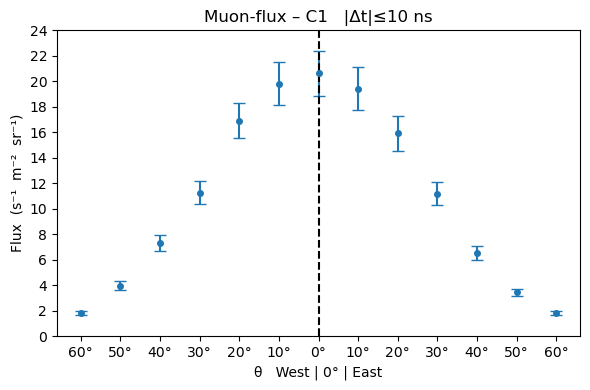

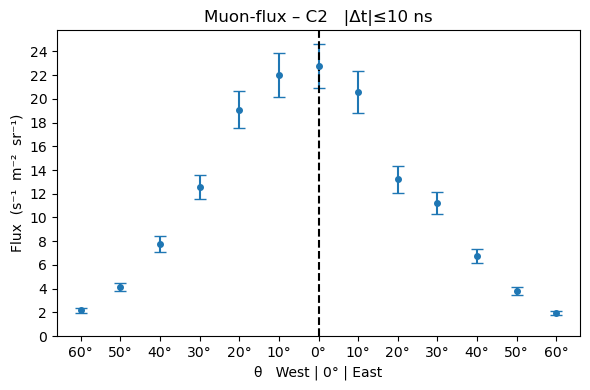

In [456]:
for pc in ["c1","c2"]:
    sub = df[df["comp"]==pc].copy()
    sub["x"] = np.where(sub["side"]=="W", -sub["angle"], sub["angle"])

    plt.figure(figsize=(6,4))
    plt.errorbar(sub["x"], sub["flux"], yerr=sub["sigma"],
                 fmt="o", capsize=4, linestyle="", markersize=4)
    plt.axvline(0, color="black", ls="--")
    plt.xticks(sub["x"], [f"{abs(v):.0f}°" for v in sub["x"]])
    plt.yticks(range(0, 26, 2))
    plt.xlabel("θ   West | 0° | East")
    plt.ylabel("Flux  (s⁻¹  m⁻²  sr⁻¹)")
    plt.title(f"Muon-flux – {pc.upper()}   |Δt|≤{BOVENGRENS} ns")
    plt.tight_layout()
    plt.show()

FIT

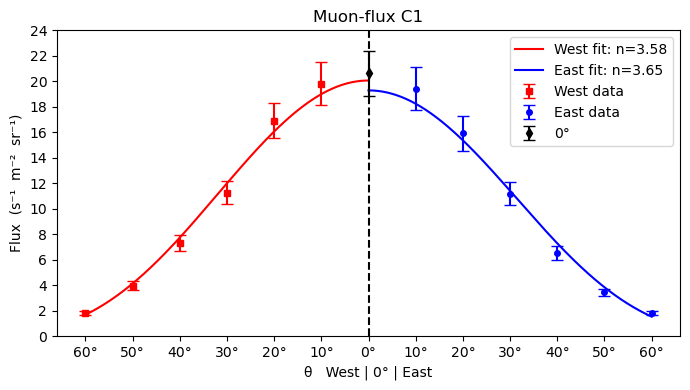

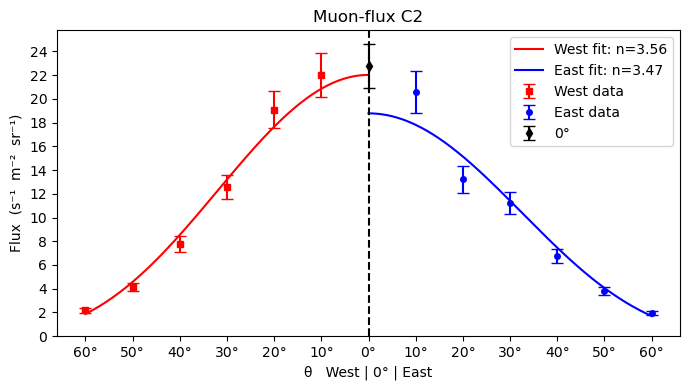

C1 E: A = 19.288 ± 0.894,  n = 3.652 ± 0.144,  χ²_red = 1.66,  p = 0.141
C1 W: A = 20.063 ± 0.901,  n = 3.577 ± 0.139,  χ²_red = 0.54,  p = 0.750
C2 E: A = 18.775 ± 0.871,  n = 3.466 ± 0.143,  χ²_red = 2.86,  p = 0.014
C2 W: A = 22.013 ± 0.997,  n = 3.558 ± 0.143,  χ²_red = 1.52,  p = 0.181


In [457]:
from scipy.optimize import curve_fit
from scipy.stats import chi2 as chi2_dist

def cosn(theta_deg, A, n):
    """A · cos^n(|θ|)   ; θ in graden."""
    return A * np.cos(np.deg2rad(np.abs(theta_deg)))**n

fit_dict = {}   # (pc, side) → popt, pcov, arrays

for pc in ["c1", "c2"]:
    sub = df[df["comp"] == pc].copy()
    sub["x"] = np.where(sub["side"]=="W", -sub["angle"], sub["angle"])

    east   = sub[sub["side"] == "E"]
    west   = sub[sub["side"] == "W"]
    center = sub[sub["side"] == "C"]

    xE, yE, sE = east["angle"].values.copy(), east["flux"].values.copy(), east["sigma"].values.copy()
    xW, yW, sW = west["angle"].values.copy(), west["flux"].values.copy(), west["sigma"].values.copy()

    if not center.empty:
        xE = np.append(xE, 0)
        yE = np.append(yE, center["flux"].values)
        sE = np.append(sE, center["sigma"].values)

        xW = np.append(xW, 0)
        yW = np.append(yW, center["flux"].values)
        sW = np.append(sW, center["sigma"].values)

    poptE, pcovE = curve_fit(cosn, xE, yE, p0=(yE.max(), 2),
                             sigma=sE, absolute_sigma=True)
    poptW, pcovW = curve_fit(cosn, xW, yW, p0=(yW.max(), 2),
                             sigma=sW, absolute_sigma=True)

    fit_dict[(pc,"E")] = (poptE, pcovE, xE, yE, sE)
    fit_dict[(pc,"W")] = (poptW, pcovW, xW, yW, sW)

    θ_grid = np.linspace(0, sub["angle"].max(), 300)
    plt.figure(figsize=(7,4))
    plt.errorbar(west["x"], yW[:-1] if not center.empty else yW,     # west-data
                 yerr=sW[:-1] if not center.empty else sW,
                 fmt="rs", markersize=4, capsize=4, label="West data")
    plt.errorbar(east["x"], yE[:-1] if not center.empty else yE,     # east-data
                 yerr=sE[:-1] if not center.empty else sE,
                 fmt="bo", markersize=4, capsize=4, label="East data")

    if not center.empty:
        plt.errorbar(0, center["flux"].values, yerr=center["sigma"].values,
                     fmt="kd", markersize=5, capsize=4, label="0°")

    plt.plot(-θ_grid, cosn(θ_grid,*poptW), "r-", label=f"West fit: n={poptW[1]:.2f}")
    plt.plot( θ_grid, cosn(θ_grid,*poptE), "b-", label=f"East fit: n={poptE[1]:.2f}")

    plt.axvline(0, color="k", ls="--")
    xticks = sorted(sub["x"].unique())
    plt.xticks(xticks, [f"{abs(t):.0f}°" for t in xticks])
    plt.yticks(range(0, 26, 2))
    plt.xlabel("θ   West | 0° | East")
    plt.ylabel("Flux  (s⁻¹  m⁻²  sr⁻¹)")
    plt.title(f"Muon-flux {pc.upper()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def chisq(y, f, s): return np.sum(((y-f)/s)**2)

for (pc, side), (popt, pcov, x, y, s) in fit_dict.items():
    y_fit = cosn(x, *popt)
    χ2    = chisq(y, y_fit, s)
    dof   = len(x) - len(popt)
    A, n  = popt
    σA, σn = np.sqrt(np.diag(pcov))
    χ2red = χ2 / dof
    p_val = 1 - chi2_dist.cdf(χ2, dof)

    print(f"{pc.upper()} {side}: "
          f"A = {A:.3f} ± {σA:.3f},  "
          f"n = {n:.3f} ± {σn:.3f},  "
          f"χ²_red = {χ2red:.2f},  p = {p_val:.3f}")


Beide Grafieken

/var/folders/8y/9x4w8xn975vbjnqg45qs6hrc0000gn/T/ipykernel_88247/370736103.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(wmean)


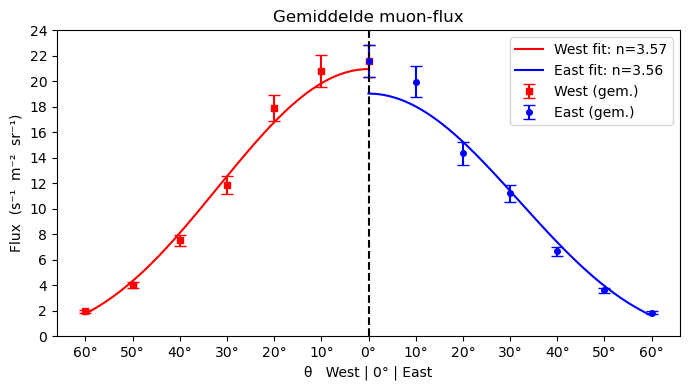

East :  A = 19.037 ± 0.625,  n = 3.563 ± 0.102,  χ²_red = 3.83
West :  A = 20.959 ± 0.669,  n = 3.570 ± 0.100,  χ²_red = 1.72


In [458]:
def wmean(group):
    w = 1 / group["sigma"]**2
    flux = (w * group["flux"]).sum() / w.sum()
    sigma = np.sqrt(1 / w.sum())
    return pd.Series({"flux": flux, "sigma": sigma})

mean_df = (df.groupby(["angle", "side"])
             .apply(wmean)
             .reset_index())

west = mean_df[mean_df["side"] == "W"].copy()
east = mean_df[mean_df["side"] == "E"].copy()
center = mean_df[mean_df["side"] == "C"]

if not center.empty:
    west = pd.concat([west, center], ignore_index=True)
    east = pd.concat([east, center], ignore_index=True)

west["x"] = -west["angle"]
east["x"] =  east["angle"]

xW, yW, sW = west["angle"].values, west["flux"].values, west["sigma"].values
xE, yE, sE = east["angle"].values, east["flux"].values, east["sigma"].values

# cosⁿ-fits
def cosn(theta_deg, A, n):
    return A * np.cos(np.deg2rad(np.abs(theta_deg))) ** n

poptW, pcovW = curve_fit(cosn, xW, yW, p0=(yW.max(), 2.0),
                         sigma=sW, absolute_sigma=True)
poptE, pcovE = curve_fit(cosn, xE, yE, p0=(yE.max(), 2.0),
                         sigma=sE, absolute_sigma=True)

A_W, n_W = poptW
A_E, n_E = poptE
σA_W, σn_W = np.sqrt(np.diag(pcovW))
σA_E, σn_E = np.sqrt(np.diag(pcovE))

# χ² / p-value
def chisq(y, f, s): return np.sum(((y - f) / s) ** 2)

χ2_W, dof_W = chisq(yW, cosn(xW,*poptW), sW), len(xW)-len(poptW)
χ2_E, dof_E = chisq(yE, cosn(xE,*poptE), sE), len(xE)-len(poptE)

# plot
θ_grid = np.linspace(0, mean_df["angle"].max(), 300)
plt.figure(figsize=(7,4))
plt.errorbar(west["x"], yW, yerr=sW, fmt="rs", markersize=4,
             capsize=4, label="West (gem.)")
plt.errorbar(east["x"], yE, yerr=sE, fmt="bo", markersize=4,
             capsize=4, label="East (gem.)")
plt.plot(-θ_grid, cosn(θ_grid,*poptW), "r-",
         label=f"West fit: n={n_W:.2f}")
plt.plot( θ_grid, cosn(θ_grid,*poptE), "b-",
         label=f"East fit: n={n_E:.2f}")

plt.axvline(0, color="k", ls="--")
xticks = sorted(sub["x"].unique())
plt.xticks(xticks, [f"{abs(t):.0f}°" for t in xticks])
plt.yticks(range(0, 26, 2))
plt.xlabel("θ   West | 0° | East")
plt.ylabel("Flux  (s⁻¹  m⁻²  sr⁻¹)")
plt.title("Gemiddelde muon-flux")
plt.legend()
plt.tight_layout()
plt.show()

# resultaten printen
print(f"East :  A = {A_E:.3f} ± {σA_E:.3f},  n = {n_E:.3f} ± {σn_E:.3f},  "
      f"χ²_red = {χ2_E/(len(xE)-2):.2f}")
print(f"West :  A = {A_W:.3f} ± {σA_W:.3f},  n = {n_W:.3f} ± {σn_W:.3f},  "
      f"χ²_red = {χ2_W/(len(xW)-2):.2f}")


In [459]:
def diff_table(pc):
    east = df.query("comp==@pc and side=='E'").set_index("angle")["flux"]
    west = df.query("comp==@pc and side=='W'").set_index("angle")["flux"]

    common = sorted(set(east.index) & set(west.index))
    rows = []
    for ang in common:
        IE, IW = east[ang], west[ang]
        delta  = IE - IW
        perc   = 100 * delta / ((IE + IW)/2)
        rows.append(dict(
            angle = ang,
            diff  = delta,
            pct   = perc
        ))
    return pd.DataFrame(rows).set_index("angle")

tbl_c1 = diff_table("c1").rename(columns={"diff":"Δ c1","pct":"%Δ c1"})
tbl_c2 = diff_table("c2").rename(columns={"diff":"Δ c2","pct":"%Δ c2"})

diff_df = tbl_c1.join(tbl_c2, how="outer").sort_index()

fmt = {
    "Δ c1":  "{:.2f}".format,
    "%Δ c1": "{:.2f}%".format,
    "Δ c2":  "{:.2f}".format,
    "%Δ c2": "{:.2f}%".format,
}

print("\nOost-West-verschil per hoek")
print(diff_df.to_string(formatters=fmt))




Oost-West-verschil per hoek
       Δ c1   %Δ c1  Δ c2   %Δ c2
angle                            
10    -0.38  -1.95% -1.44  -6.75%
20    -0.99  -6.05% -5.86 -36.29%
30    -0.06  -0.55% -1.38 -11.60%
40    -0.74 -10.70% -1.01 -13.89%
50    -0.53 -14.15% -0.34  -8.46%
60     0.00   0.09% -0.25 -12.00%


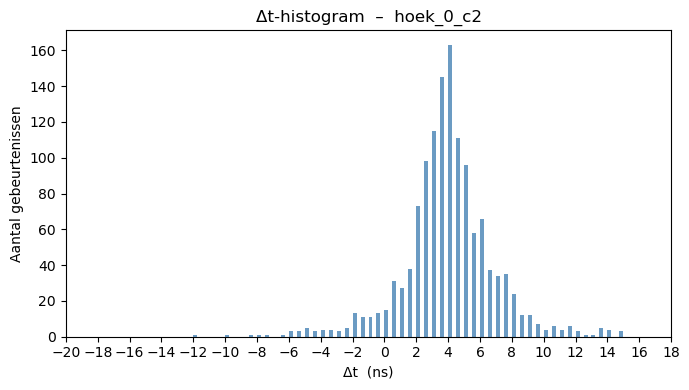

In [460]:
FILE_TO_PLOT = "hoek_0_c2.csv"

df_run = pd.read_csv(FILE_TO_PLOT)
dt = df_run["Delta times (ns)"].dropna().astype(float)

# tekenflip voor pc 2
if "_c2" in FILE_TO_PLOT:
    dt = -dt

plt.figure(figsize=(7,4))
plt.hist(dt, bins=120, range=(-15, 15),
         orientation="vertical", color="steelblue", alpha=0.8)

plt.xticks(range(-20, 20, 2))

plt.ylabel("Aantal gebeurtenissen")   # y-as = counts
plt.xlabel("Δt  (ns)")                # x-as = tijdverschil
plt.title(f"Δt-histogram  –  {Path(FILE_TO_PLOT).stem}")
plt.tight_layout()
plt.show()


Gemiddelde asymmetrie c1 : +5.553%
Gemiddelde asymmetrie c2 : +14.831%

Asymmetrie per hoek (positief = West > East)
          A_c1     A_c2
angle                  
10     +1.955%  +6.746%
20     +6.052% +36.288%
30     +0.554% +11.604%
40    +10.705% +13.885%
50    +14.147%  +8.462%
60     -0.092% +12.003%


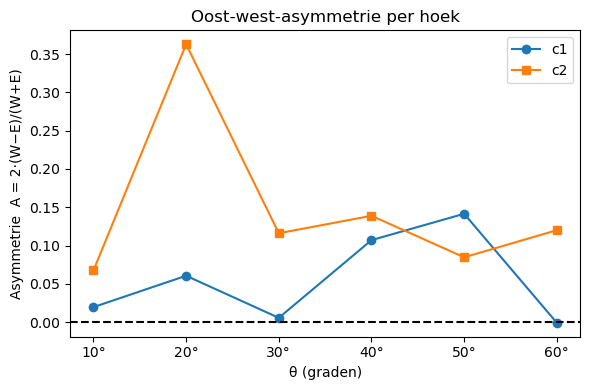

In [461]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def asymmetry_one_pc(pc_name: str) -> pd.DataFrame:
    west_flux = (df.query("comp == @pc_name and side == 'W'")
                   .set_index("angle")["flux"])
    east_flux = (df.query("comp == @pc_name and side == 'E'")
                   .set_index("angle")["flux"])

    common_angles = sorted(set(west_flux.index) & set(east_flux.index))
    A_vals = 2 * (west_flux.loc[common_angles] - east_flux.loc[common_angles]) \
               / (west_flux.loc[common_angles] + east_flux.loc[common_angles])

    return pd.DataFrame({"A": A_vals})

# asymmetrie per PC
A_c1 = asymmetry_one_pc("c1")
A_c2 = asymmetry_one_pc("c2")

mean_A_c1 = A_c1["A"].mean()
mean_A_c2 = A_c2["A"].mean()

print(f"Gemiddelde asymmetrie c1 : {mean_A_c1:+.3%}")
print(f"Gemiddelde asymmetrie c2 : {mean_A_c2:+.3%}\n")

asym_table = (A_c1.rename(columns={"A": "A_c1"})
                .join(A_c2.rename(columns={"A": "A_c2"}), how="outer"))

print("Asymmetrie per hoek (positief = West > East)")
print(asym_table.to_string(float_format="{:+.3%}".format))

plt.figure(figsize=(6,4))
plt.plot(A_c1.index, A_c1["A"], "o-", label="c1")
plt.plot(A_c2.index, A_c2["A"], "s-", label="c2")
plt.axhline(0, color="k", ls="--")
plt.xticks(sorted(asym_table.index), [f"{ang}°" for ang in asym_table.index])
plt.xlabel("θ (graden)")
plt.ylabel("Asymmetrie  A = 2·(W−E)/(W+E)")
plt.title("Oost-west-asymmetrie per hoek")
plt.legend()
plt.tight_layout()
plt.show()
